In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [2]:
#import dataset
fraud_data = pd.read_csv("Fraud_check.csv")
fraud_data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


### EDA

In [3]:
#Check for NA values
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [4]:
#Check for duplicate records
fraud_data[fraud_data.duplicated()]

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban


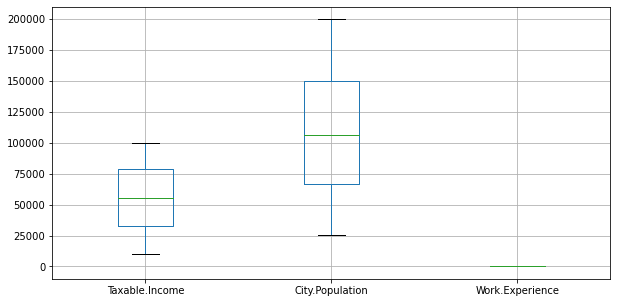

In [5]:
#Boxplot for outliers
fraud_data.boxplot(figsize=(10,5));

In [6]:
#dependent variable
fraud_data_eda = fraud_data.copy()
fraud_data_eda["fraud"] = ["Risky" if x <= 30000 else "Good" for x in fraud_data_eda["Taxable.Income"]] 
fraud_data_eda.drop(labels=["Taxable.Income"], axis=1,inplace=True)

In [7]:
#Checking outliers using Isolation forest with contamination = 0.01
from sklearn.ensemble import IsolationForest

isf =IsolationForest(contamination=0.01, random_state=0)
y_isf = isf.fit_predict(pd.get_dummies(fraud_data_eda))
outlier_index = np.where(y_isf == -1)
outlier_index

(array([ 16,  34, 259, 280, 517, 541], dtype=int64),)

In [8]:
#Removal of outliers
fraud_data_final = fraud_data_eda.drop(index=outlier_index[0],axis=0)
fraud_data_final.reset_index(inplace=True,drop=True)

In [9]:
#Dividing dependent and independet variables
x = pd.get_dummies(fraud_data_final.iloc[:,0:-1])
y = LabelEncoder().fit_transform(fraud_data_final.iloc[:,-1]) #Risky = 0, Good =1

In [10]:
#train and test data split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=0)

## Model

In [11]:
#Find the best parameters for the model
Classifier = RandomForestClassifier(random_state=1)
para_grid = [{"n_estimators":[100,150,200,300,500],"criterion":["gini","entropy"],"max_depth":[3,4,5]}]
gsv = GridSearchCV(Classifier,para_grid)
gsv.fit(x_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [3, 4, 5],
                          'n_estimators': [100, 150, 200, 300, 500]}])

In [12]:
#Best parameters
gsv.best_params_, gsv.best_score_

({'criterion': 'gini', 'max_depth': 3, 'n_estimators': 100},
 0.8042105263157895)

In [13]:
#Model
classifier_final = RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=3, random_state=0)
classifier_final.fit(x_train,y_train)
#model score on trained data
classifier_final.score(x_train,y_train)

0.8042105263157895

In [14]:
#Model score on test data
round(classifier_final.score(x_test,y_test),3)

0.79